<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/Simple_Prophet_All_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import prophet
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'], index_col = ['date'])

In [4]:
# Simple Prophet
# Group by contries

In [12]:
train_col_of_interest = train[['country_code', 'new_confirmed']]
test_col_of_interest = test[['country_code', 'new_confirmed']]

In [13]:
train_col_of_interest_gp = train_col_of_interest.groupby(['country_code','date'])
test_col_of_interest_gp = test_col_of_interest.groupby(['country_code','date'])

In [14]:
train_agg = train_col_of_interest_gp.agg('sum')
train_agg.reset_index(level = 'country_code', inplace = True)
test_agg = test_col_of_interest_gp.agg('sum')
test_agg.reset_index(level = 'country_code', inplace = True)

In [15]:
# Use US as a representative
US_train = train_agg.loc[train_agg.country_code == 'US','new_confirmed']
US_test = test_agg.loc[test_agg.country_code == 'US','new_confirmed']

In [18]:
US_train = US_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
US_test = US_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})

In [19]:
# fit a prophet model
model_US = prophet.Prophet().fit(US_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvr0v3nr7/myuesvv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvr0v3nr7/0d7o3tfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78115', 'data', 'file=/tmp/tmpvr0v3nr7/myuesvv8.json', 'init=/tmp/tmpvr0v3nr7/0d7o3tfl.json', 'output', 'file=/tmp/tmpvr0v3nr7/prophet_modeln6ohpcwf/prophet_model-20231112194544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
US_train_predict = model_US.predict(US_train)
US_train_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-13,-13626.528931,-63500.974463,64041.908448,-13626.528931,-13626.528931,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,10871.836988,0.0,0.0,0.0,-2754.691942
1,2020-01-14,-13290.680926,-76606.229532,53213.547648,-13290.680926,-13290.680926,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,2104.942909,0.0,0.0,0.0,-11185.738017
2,2020-01-15,-12954.832921,-72416.886271,61446.124499,-12954.832921,-12954.832921,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,9122.647027,0.0,0.0,0.0,-3832.185894
3,2020-01-16,-12618.984917,-73814.978094,62137.380501,-12618.984917,-12618.984917,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,7341.185615,0.0,0.0,0.0,-5277.799302
4,2020-01-17,-12283.136912,-72872.579067,65095.015580,-12283.136912,-12283.136912,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,10048.997440,0.0,0.0,0.0,-2234.139472


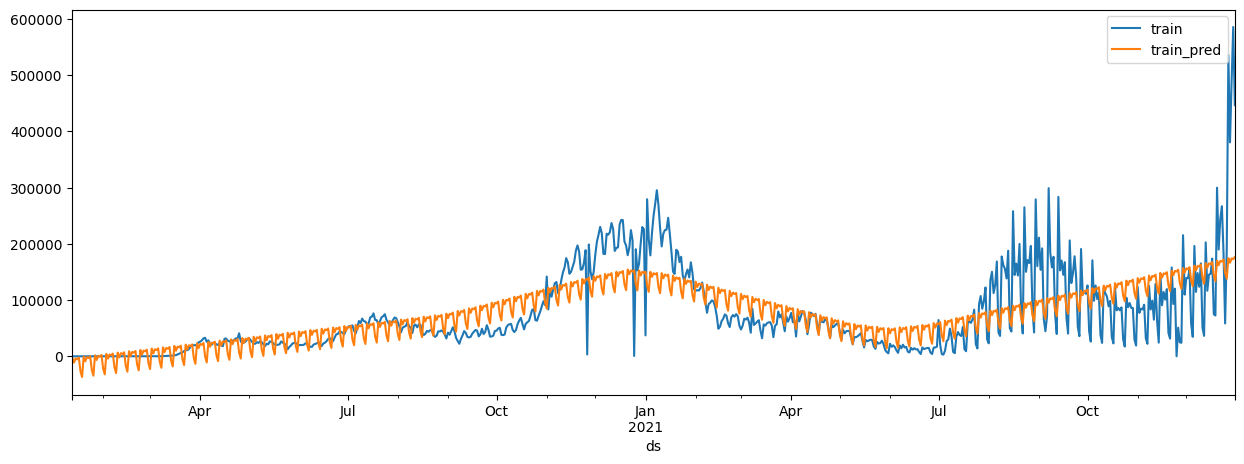

In [21]:
# make the date the index column for y_train and y_train_predict
US_train_predict_y = US_train_predict[['ds','yhat']].set_index('ds')
US_train_date_index = US_train.set_index('ds')
pd.concat([US_train_date_index,US_train_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

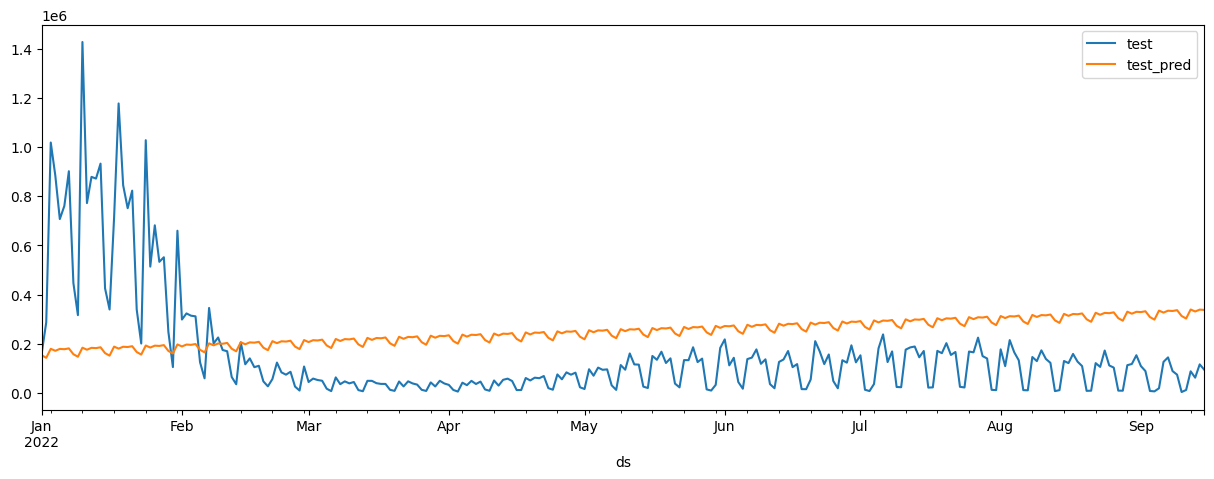

In [22]:
# predict the testing data
US_test_predict = model_US.predict(US_test)
US_test_predict_y = US_test_predict[['ds','yhat']].set_index('ds')
US_test_date_index = US_test.set_index('ds')
pd.concat([US_test_date_index,US_test_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['test', 'test_pred'])

In [24]:
print('The RMSE of the training data is ', mean_squared_error(US_train_date_index, US_train_predict_y, squared=False))
print('The RMSE of the testing data is ', mean_squared_error(US_test_date_index, US_test_predict_y, squared=False))

The RMSE of the training data is  51310.51790167791
The RMSE of the testing data is  261479.0080693557


In [25]:


train_sel_sig_prophet = train[['location_key_x', 'new_confirmed']]
test_sel_sig_prophet = test[['location_key_x', 'new_confirmed']]

# Apply the model to all countries
# making a pred_train and pred_test dataset
train_pred = train_sel_sig_prophet.copy()
train_pred.new_confirmed = None
train_pred.columns = ['location_key_x','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])
#train_pred.rename(columns={'date':'ds', 'new_confirmed':'y'}, inplace = True)

test_pred = test_sel_sig_prophet.copy()
test_pred.new_confirmed = None
test_pred.columns = ['location_key_x','predicted_new_confirmed']
test_pred.reset_index(inplace = True)
#test_pred.rename(columns={'date':'ds', 'new_confirmed':'y'},  inplace = True)

In [26]:
train_pred

,date,location_key_x,predicted_new_confirmed
0,2020-01-22,US_AK,None
1,2020-01-23,US_AK,None
2,2020-01-24,US_AK,None
3,2020-01-25,US_AK,None
4,2020-01-26,US_AK,None
...,...,...,...
69908,2021-12-27,AU_WA,None
69909,2021-12-28,AU_WA,None
69910,2021-12-29,AU_WA,None
69911,2021-12-30,AU_WA,None


In [31]:
# Apply the model to all countries
# making a pred_train and pred_test dataset
train_pred = train_agg.copy()
train_pred.new_confirmed = None
train_pred.columns = ['country_code','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])
#train_pred.rename(columns={'date':'ds', 'new_confirmed':'y'}, inplace = True)

test_pred = test_agg.copy()
test_pred.new_confirmed = None
test_pred.columns = ['country_code','predicted_new_confirmed']
test_pred.reset_index(inplace = True)
#test_pred.rename(columns={'date':'ds', 'new_confirmed':'y'},  inplace = True)

In [36]:
start_time = time.time()

loc_list = list(train_agg.country_code.unique())

for loc in loc_list:
  # initialize the dataset
  train_interest = train_agg.loc[train_agg.country_code == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_agg.loc[test_agg.country_code == loc, 'new_confirmed'] # select the rows in the testing data
  train_interest = train_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  test_interest = test_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  # fit the model on the train dataset
  model = prophet.Prophet().fit(train_interest)
  pred_for_train = model.predict(train_interest)
  for date in pred_for_train.ds:
    train_pred.loc[(train_pred.country_code == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.ds == date, 'yhat'])
  # predict test dataset
  pred_for_test = model.predict(test_interest)
  for date in pred_for_test.ds:
    test_pred.loc[(test_pred.country_code == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.ds == date, 'yhat'])

print("Time taken = ", round((time.time()-start_time)/60), " minutes")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvr0v3nr7/_cy0klrr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvr0v3nr7/xfr5nwwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70000', 'data', 'file=/tmp/tmpvr0v3nr7/_cy0klrr.json', 'init=/tmp/tmpvr0v3nr7/xfr5nwwu.json', 'output', 'file=/tmp/tmpvr0v3nr7/prophet_modelloeqyzx9/prophet_model-20231112200006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Time taken =  0  minutes


In [37]:
train_pred

,date,country_code,predicted_new_confirmed
0,2020-01-27,AU,9.810605
1,2020-01-29,AU,16.904663
2,2020-01-30,AU,18.889247
3,2020-02-01,AU,7.268472
4,2020-02-04,AU,11.408295
...,...,...,...
7046,2021-12-27,US,174664.744561
7047,2021-12-28,US,166532.727758
7048,2021-12-29,US,174185.309152
7049,2021-12-30,US,173038.725015


In [38]:
test_pred

,date,country_code,predicted_new_confirmed
0,2022-01-01,AU,209.77383
1,2022-01-02,AU,212.915365
2,2022-01-03,AU,215.509063
3,2022-01-04,AU,219.215717
4,2022-01-05,AU,226.137829
...,...,...,...
2565,2022-09-11,US,302365.326021
2566,2022-09-12,US,339097.959016
2567,2022-09-13,US,330965.942212
2568,2022-09-14,US,338618.523607


In [40]:
print("the rmse on the training data is ", mean_squared_error(train_agg.new_confirmed, train_pred.predicted_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test_agg.new_confirmed, test_pred.predicted_new_confirmed, squared = False))

the rmse on the training data is  16406.39513436985
the rmse on the testing data is  83410.19333522438
